# Benchmarks

## Initialize

In [1]:
#library(Rmisc)
library(dtplyr)
library(tidyverse)
library(glue)
library(arrow)
library(patchwork)
library(data.table)
library("jsonlite")
library(ggthemes)

Warning message:
“package ‘tidyverse’ was built under R version 4.0.3”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

Warning message:
“package ‘ggplot2’ was built under R version 4.0.5”
Warning message:
“package ‘readr’ was built under R version 4.0.5”
Warning message:
“package ‘purrr’ was built under R version 4.0.3”
Warning message:
“package ‘dplyr’ was built under R version 4.0.5”
Warning message:
“package ‘stringr’ was built under R version 4.0.5”
Warning message:
“package ‘forcats’ was built under R version 4.0.3”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘arrow’ was built under R version 4.0.3”

Attaching package: ‘arrow’


The following object is masked from ‘p

In [2]:
if (grepl("sc", Sys.info()[["nodename"]], fixed=TRUE)) {
    base_path = "/sc-projects/sc-proj-ukb-cvd"
} else {
    base_path = "/data/analysis/ag-reils/ag-reils-shared/cardioRS"}
print(base_path)

project_label="22_medical_records"
project_path = glue("{base_path}/results/projects/{project_label}")
figure_path = glue("{project_path}/figures")
output_path = glue("{project_path}/data")

experiment = 220531
experiment_path = glue("{output_path}/{experiment}")

[1] "/sc-projects/sc-proj-ukb-cvd"


In [3]:
base_size = 8
title_size = 10
facet_size = 9
geom_text_size=3
theme_set(theme_classic(base_size = base_size) + 
          theme(strip.background = element_blank(), plot.title=element_text(size=title_size, hjust=0), 
                strip.text.x = element_text(size = facet_size),axis.title=element_text(size=10), axis.text=element_text(size=8, color="black"),
                legend.position="bottom", axis.line = element_line(size = 0.2), axis.ticks=element_line(size=0.2), panel.grid.major.y=element_line()))

In [4]:
colors_dict = read_json("colors.json")
color_map <- c(
    "Identity(AgeSex)+MLP" = colors_dict$pastel$red$mid,
    "Identity(Records)+MLP" = colors_dict$pastel$red$mid,
    "GNN(Records)+MLP" = colors_dict$pastel$red$mid,
    "Identity(AgeSex+Records)+MLP" = colors_dict$pastel$red$mid,
    "GNN(AgeSex+Records)+MLP" = colors_dict$pastel$red$mid
)

In [5]:
endpoint_defs = arrow::read_feather(glue("{output_path}/phecode_defs_220306.feather")) %>% arrange(endpoint)

In [6]:
endpoint_map = endpoint_defs$phecode_string
names(endpoint_map) =  endpoint_defs$endpoint
endpoint_order = (endpoint_defs %>% arrange(as.numeric(phecode)))$endpoint

In [7]:
endpoint_selection_df = endpoint_defs %>% filter(phecode_category == "Mental")# %>% filter(!str_detect(phecode, "\\."))
endpoint_selection = endpoint_selection_df$endpoint

In [8]:
endpoint_defs = endpoint_defs %>% 
    mutate(name = phecode_string) %>% 
    mutate(name = 
           case_when( 
               endpoint == "phecode_092-2"~"Sepsis", 
               #endpoint == "phecode_105"~"Malign breast cancer", 
               endpoint == "phecode_123"~"Malignant plasma cell neoplasms", 
               endpoint == "phecode_164"~"Anemia", 
               endpoint == "phecode_200-1"~"Hypothyroidism", 
               endpoint == "phecode_232"~"Vitamin deficiencies", 
               endpoint == "phecode_284"~"Suicide attempt or self harm", 
               #endpoint == "phecode_287-5"~"Drug-induced psychosis", 
               #endpoint == "phecode_328"~"Dementia", 
               #endpoint == "phecode_404"~"Coronary heart disease", 
               endpoint == "phecode_424"~"Heart failure", 
               endpoint == "phecode_440-11"~"Deep vein thrombosis", 
               endpoint == "phecode_468"~"Pneumonia", 
               endpoint == "phecode_474"~"COPD", 
               endpoint == "phecode_518"~"Appendicitis", 
               endpoint == "phecode_542-1"~"Fibrosis and cirrhosis of liver", 
               endpoint == "phecode_583"~"Chronic kidney disease", 
               endpoint == "phecode_705-1"~"Rheumatoid arthritis", 
               endpoint == "phecode_908-1"~"(Pre)eclampsia", 
               #endpoint == "phecode_976"~"Complication of anesthesia",
               TRUE ~ name)
           )

endpoint_map = endpoint_defs$name
names(endpoint_map) =  endpoint_defs$endpoint
endpoint_order = (endpoint_defs %>% arrange(as.numeric(phecode)))$endpoint

## Load data

# Load Benchmarks

In [10]:
name = "benchmark_cindex_agesexcoxph_220531_10"
benchmark_endpoints = arrow::read_feather(glue("{experiment_path}/{name}.feather")) %>% left_join(endpoint_defs) 

Joining, by = "endpoint"



In [11]:
benchmark_endpoints %>% group_by(endpoint, score)  %>% summarise(cindex=mean(cindex)) %>% group_by(score) %>% summarise(mean(cindex)) %>% arrange(`mean(cindex)`)

`summarise()` has grouped output by 'endpoint'. You can override using the `.groups` argument.



score,mean(cindex)
<chr>,<dbl>
Age+Sex,0.6084877
MedicalHistory,0.7240973
Age+Sex+MedicalHistory,0.7261569


In [12]:
endpoints_sorted = (benchmark_endpoints %>% 
    filter(score == "Age+Sex+MedicalHistory") %>% 
    group_by(endpoint, score) %>% 
    summarise(cindex=mean(cindex, na.rm=TRUE)) %>% 
    arrange(cindex) %>% ungroup())$endpoint

`summarise()` has grouped output by 'endpoint'. You can override using the `.groups` argument.



In [13]:
categories_sorted = (endpoint_defs %>% distinct(phecode_category))$phecode_category

`summarise()` has grouped output by 'endpoint', 'phecode_string'. You can override using the `.groups` argument.



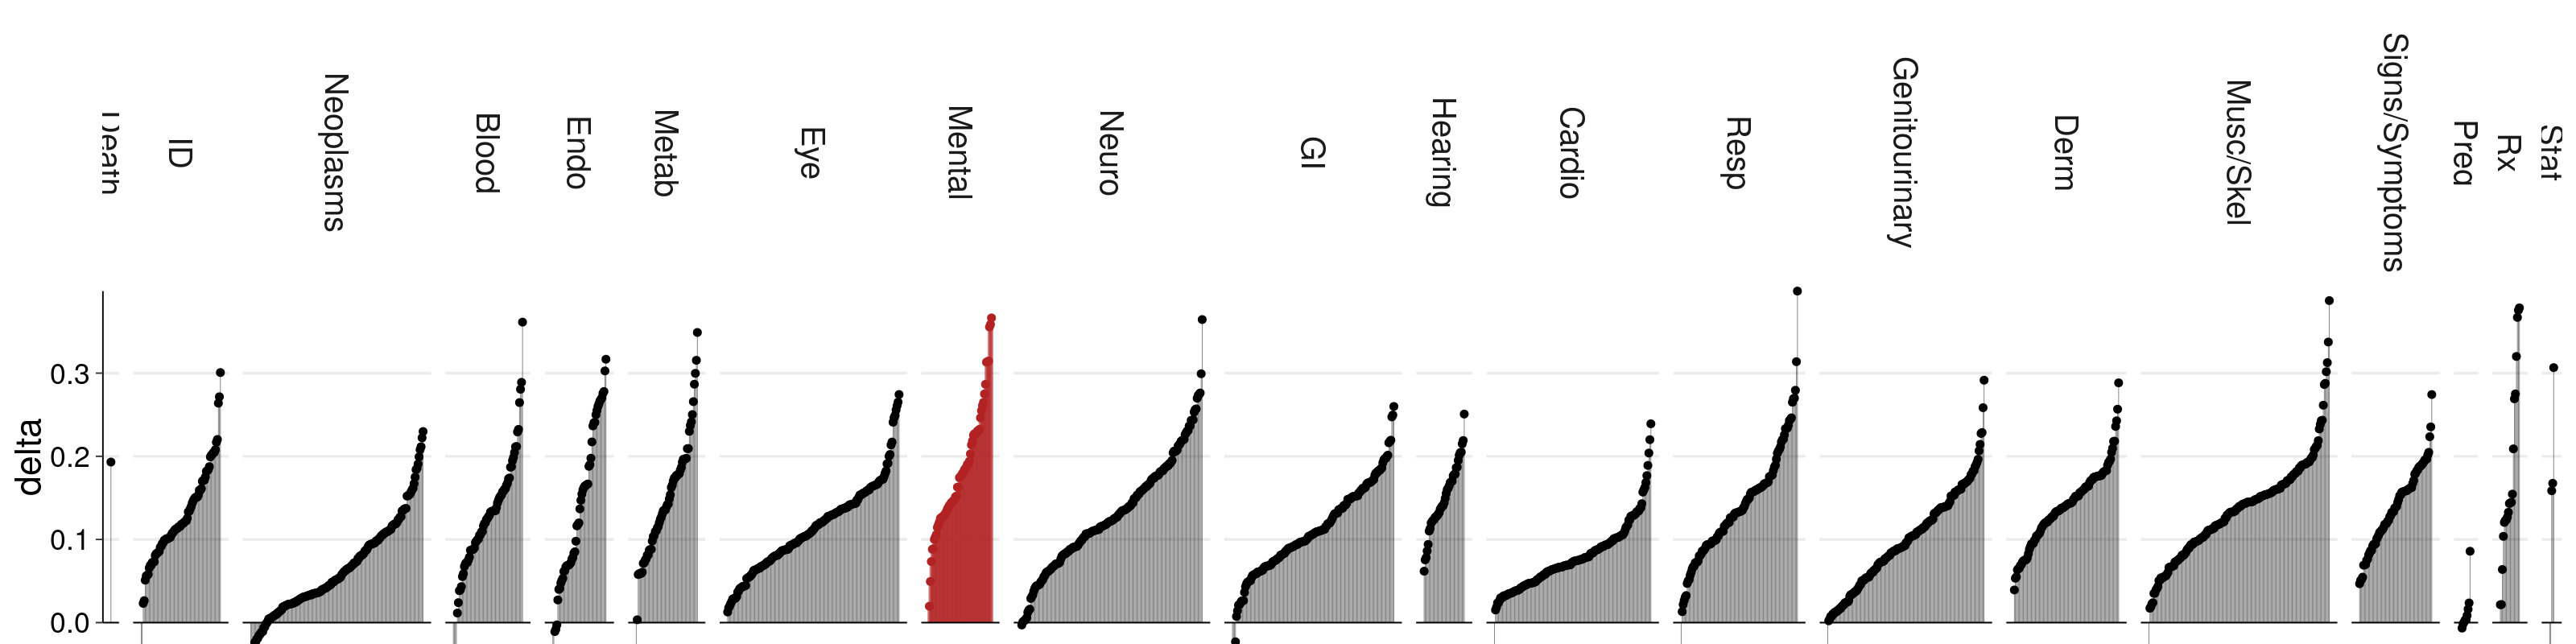

In [14]:
plot_width = 10; plot_height=2.5; plot_res = 320
options(repr.plot.width = plot_width, repr.plot.height = plot_height, repr.plot.res=plot_res)

scores_plot = c("Age+Sex", "Age+Sex+MedicalHistory")#, "AgeSexMedicalHistory")

temp = benchmark_endpoints %>% 
    filter(score %in% scores_plot) %>% 
    mutate(score = factor(score, levels=scores_plot)) %>%
    mutate(endpoint = factor(endpoint, levels=endpoints_sorted)) %>%
    ungroup() %>%
    pivot_wider(names_from=score, values_from=cindex) %>% 
    mutate(id = row_number()) %>%
    mutate(delta = `Age+Sex+MedicalHistory`-`Age+Sex`) %>%
    group_by(endpoint, phecode_string, phecode_category) %>%
    summarise(delta = median(delta)) %>%
    mutate(pos = case_when(delta>=0 ~ "pos", delta < 0 ~"neg")) %>%
    mutate(endpoint = fct_reorder(endpoint, delta)) %>%
    mutate(highlight = case_when(endpoint %in% endpoint_selection ~ "YES", TRUE ~ "NO")) %>%# %>% filter(endpoint %in% endpoint_sample)
    mutate(phecode_category = factor(phecode_category, levels=categories_sorted))

endpoint_order = (temp %>% arrange(delta))$endpoint

temp = temp %>% mutate(endpoint = factor(endpoint, levels=endpoint_order))

ggplot(temp) + 
    geom_point(aes(x=endpoint, y=delta, color=highlight), size=0.5) +
    geom_segment(aes(x=endpoint, xend=endpoint, y=0, yend=delta, color=highlight, size=highlight), alpha=0.5)+#+
    scale_color_manual(values=c("NO"="black", "YES"="firebrick"))+
    #scale_alpha_manual(values=c("NO"=0.3, "YES"=0.7))+
    scale_size_manual(values=c("NO"=0.1, "YES"=0.5))+
    #scale_colour_manual(values = c("pos"="forestgreen", "neg" = "firebrick")) + 
    coord_cartesian(ylim=c(0, NA), clip = "off")+
    scale_y_continuous(expand=c(0, 0))+
    scale_x_discrete(expand=expansion(add=8))+
    facet_grid(~phecode_category, scale="free_x", space="free_x")+#, switch=TRUE)+
    theme(axis.title.x=element_blank(),
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank(),
     strip.text = element_text(angle=270)) + 
    theme(legend.position="none")
    
    #geom_ribbon(aes(x=id, ymin=AgeSex, ymax=`Age+Sex+MedicalHistory`), fill="red", alpha=0.2)
#geom_violin(size=0.1)

In [15]:
plot_width = 8.25; plot_height=2; plot_res = 320
options(repr.plot.width = plot_width, repr.plot.height = plot_height, repr.plot.res=plot_res)

scores_plot = c("MedicalHistory", "Age+Sex", "Age+Sex+MedicalHistory")#, "AgeSexMedicalHistory")

temp = benchmark_endpoints %>% 
    filter(score %in% scores_plot) %>% 
    mutate(score = factor(score, levels=scores_plot)) %>%
    mutate(endpoint = factor(endpoint, levels=endpoints_sorted)) %>%
    group_by(endpoint, score, phecode_string, phecode_category) %>%
    ungroup() %>%
    pivot_wider(names_from=score, values_from=cindex) %>% 
    mutate(id = row_number()) %>%
    mutate(delta = `Age+Sex+MedicalHistory`-`Age+Sex`) %>%
    #mutate(delta_int = `Age+Sex+MedicalHistory`-`Age+Sex+MedicalHistory`) %>%
    mutate(pos = case_when(delta>=0 ~ "pos", delta < 0 ~"neg")) %>%
    mutate(endpoint = fct_reorder(endpoint, delta)) %>%
    mutate(highlight = case_when(endpoint %in% endpoint_selection ~ "YES", TRUE ~ "NO")) %>%# %>% filter(endpoint %in% endpoint_sample)
    mutate(phecode_category = factor(phecode_category, levels=categories_sorted)) %>%
    filter(endpoint %in% endpoint_selection)
    #%>%
    #summarise(cindex = mean(cindex)) 
temp

endpoint,iteration,time,phecode,phecode_string,phecode_category,sex,ICD10_only,phecode_top,leaf,name,Age+Sex,MedicalHistory,Age+Sex+MedicalHistory,id,delta,pos,highlight
<fct>,<int>,<int>,<chr>,<chr>,<fct>,<chr>,<int>,<chr>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<chr>,<chr>
phecode_280,0,10,280,Substance related disorders,Mental,Both,0,280,0,Substance related disorders,0.5888163,0.6899222,0.6902817,4401,0.10146535,pos,YES
phecode_280,1,10,280,Substance related disorders,Mental,Both,0,280,0,Substance related disorders,0.5835711,0.6860543,0.6864062,4402,0.10283509,pos,YES
phecode_280,2,10,280,Substance related disorders,Mental,Both,0,280,0,Substance related disorders,0.5828093,0.6875012,0.6878468,4403,0.10503752,pos,YES
phecode_280,3,10,280,Substance related disorders,Mental,Both,0,280,0,Substance related disorders,0.5839526,0.6902230,0.6906854,4404,0.10673286,pos,YES
phecode_280,4,10,280,Substance related disorders,Mental,Both,0,280,0,Substance related disorders,0.5828053,0.6878471,0.6881773,4405,0.10537201,pos,YES
phecode_280,5,10,280,Substance related disorders,Mental,Both,0,280,0,Substance related disorders,0.5808604,0.6874073,0.6877947,4406,0.10693434,pos,YES
phecode_280,6,10,280,Substance related disorders,Mental,Both,0,280,0,Substance related disorders,0.5836510,0.6885048,0.6889292,4407,0.10527821,pos,YES
phecode_280,7,10,280,Substance related disorders,Mental,Both,0,280,0,Substance related disorders,0.5812527,0.6871890,0.6874584,4408,0.10620578,pos,YES
phecode_280,8,10,280,Substance related disorders,Mental,Both,0,280,0,Substance related disorders,0.5819855,0.6882104,0.6886907,4409,0.10670522,pos,YES


In [16]:
library(ggdist)

Warning message:
“package ‘ggdist’ was built under R version 4.0.5”


In [17]:
base_size = 8
title_size = 10
facet_size = 9
geom_text_size=3
theme_set(theme_classic(base_size = base_size) + 
          theme(strip.background = element_blank(), plot.title=element_text(size=title_size, hjust=0), 
                strip.text.x = element_text(size = facet_size),axis.title=element_text(size=10), axis.text=element_text(size=8, color="black"),
                legend.position="bottom", axis.line = element_line(size = 0.2), axis.ticks=element_line(size=0.2), panel.grid.major=element_line()))

Coordinate system already present. Adding new coordinate system, which will replace the existing one.



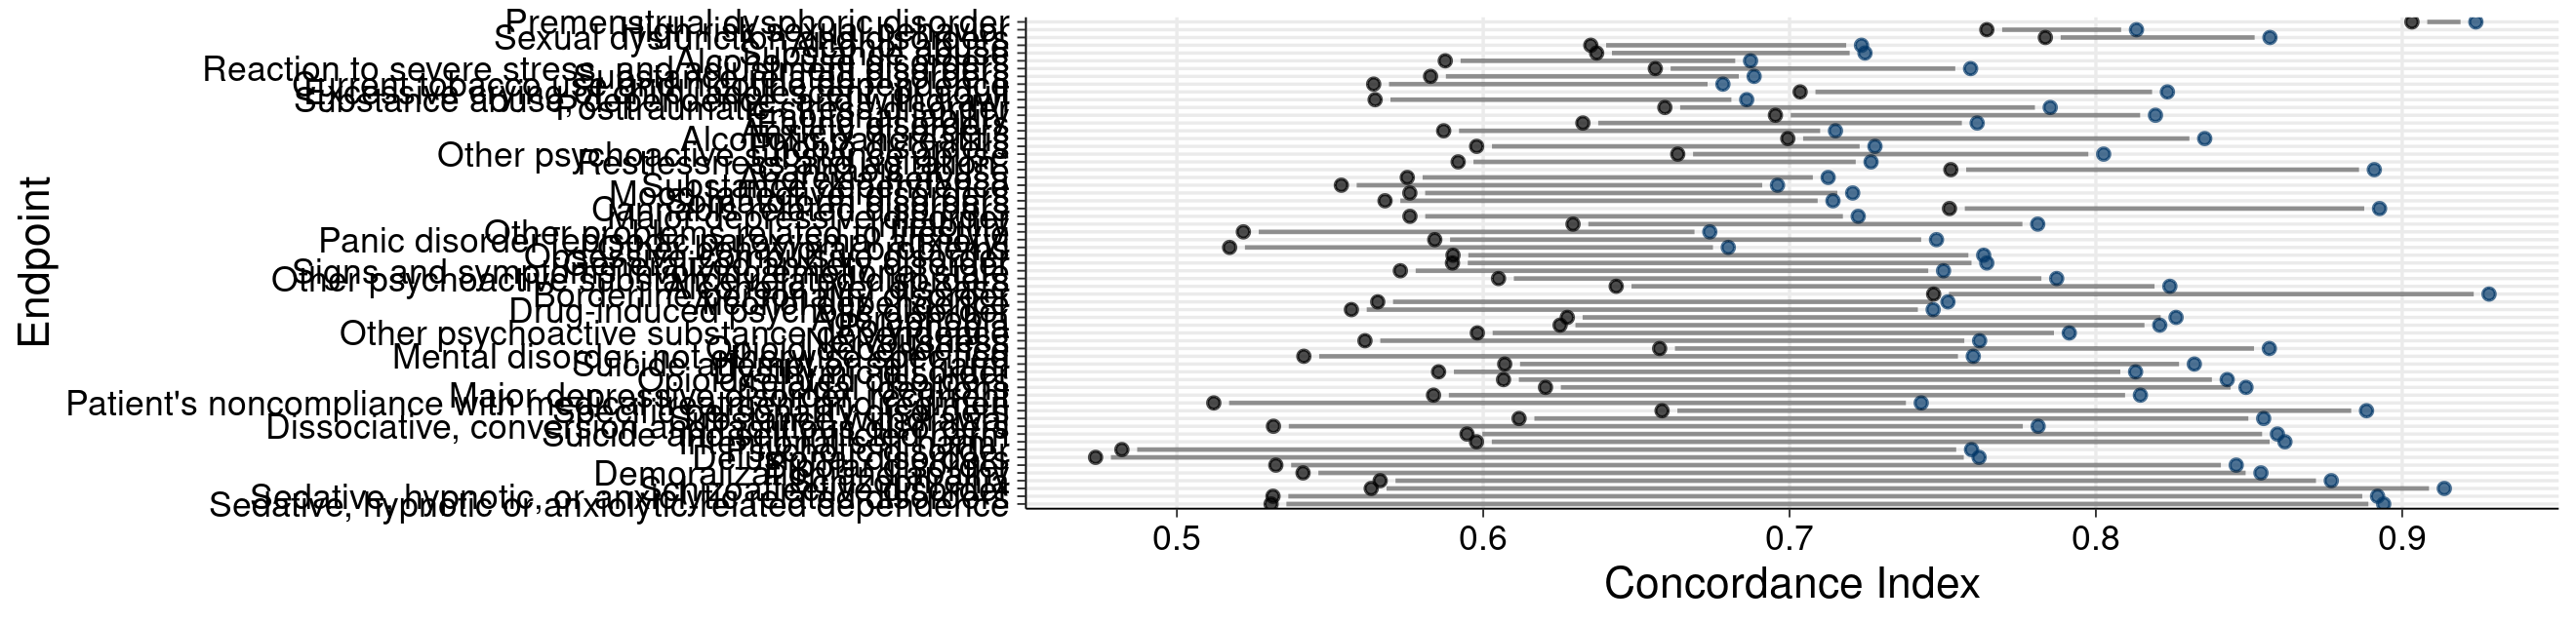

In [18]:
abs = ggplot(temp %>% group_by(endpoint) %>% summarise(m_asm=median(`Age+Sex+MedicalHistory`), m_as=median(`Age+Sex`))) + 
    #geom_violin(aes(x=fct_rev(endpoint), y=delta), size=0.5) +
    labs(y="Concordance Index", x="Endpoint")+
    #stat_pointinterval(aes(x=fct_rev(endpoint), y=`Age+Sex`), size=1, color="black", alpha=0.3)+
    #stat_pointinterval(aes(x=fct_rev(endpoint), y=`Age+Sex+MedicalHistory`), size=1, color="#023768", alpha=0.5)+
    geom_point(aes(x=fct_rev(endpoint), y=m_as), size=1, color="black", alpha=0.7)+
    geom_point(aes(x=fct_rev(endpoint), y=m_asm), size=1, color="#023768", alpha=0.7)+
    geom_segment(aes(x=endpoint, xend=endpoint, y=m_as+0.005, yend=m_asm-0.005), alpha=0.4)+#+
    #scale_color_manual(values=c("NO"="black", "YES"="firebrick"))+
    #scale_alpha_manual(values=c("NO"=0.3, "YES"=0.7))+
    #scale_size_manual(values=c("NO"=0.1, "YES"=0.5))+
    #scale_colour_manual(values = c("pos"="forestgreen", "neg" = "firebrick")) + 
    coord_cartesian(ylim=c(0, NA), clip = "off")+
    scale_x_discrete(labels=endpoint_map) +
    #scale_y_continuous(expand=c(0, 0))+
    #theme(axis.title.x=element_blank(),
     #   axis.text.x=element_blank(),
      #  axis.ticks.x=element_blank(),
    coord_flip()+
     theme(strip.text = element_text(angle=270)) + 
    theme(legend.position="none")
    
    #geom_ribbon(aes(x=id, ymin=AgeSex, ymax=`Age+Sex+MedicalHistory`), fill="red", alpha=0.2)
#geom_violin(size=0.1)
abs 

In [19]:
rel = ggplot(temp) + 
    #geom_violin(aes(x=fct_rev(endpoint), y=delta), size=0.5) +
    labs(y="Difference in Concordance Index")+
    stat_pointinterval(aes(x=fct_rev(endpoint), y=delta), size=0.5)+
    #geom_segment(aes(x=endpoint, xend=endpoint, y=0, yend=delta, color=highlight, size=highlight), alpha=0.5)+#+
    #scale_color_manual(values=c("NO"="black", "YES"="firebrick"))+
    #scale_alpha_manual(values=c("NO"=0.3, "YES"=0.7))+
    #scale_size_manual(values=c("NO"=0.1, "YES"=0.5))+
    #scale_colour_manual(values = c("pos"="forestgreen", "neg" = "firebrick")) + 
    coord_cartesian(ylim=c(0, NA), clip = "off")+
    #scale_y_continuous(expand=c(0, 0))+
    theme(axis.title.y=element_blank(),
        axis.text.y=element_blank(),
       axis.ticks.y=element_blank()) + 
    coord_flip()+
     theme(strip.text = element_text(angle=270)) + 
    theme(legend.position="none")
    
    #geom_ribbon(aes(x=id, ymin=AgeSex, ymax=`Age+Sex+MedicalHistory`), fill="red", alpha=0.2)
#geom_violin(size=0.1) 

Coordinate system already present. Adding new coordinate system, which will replace the existing one.



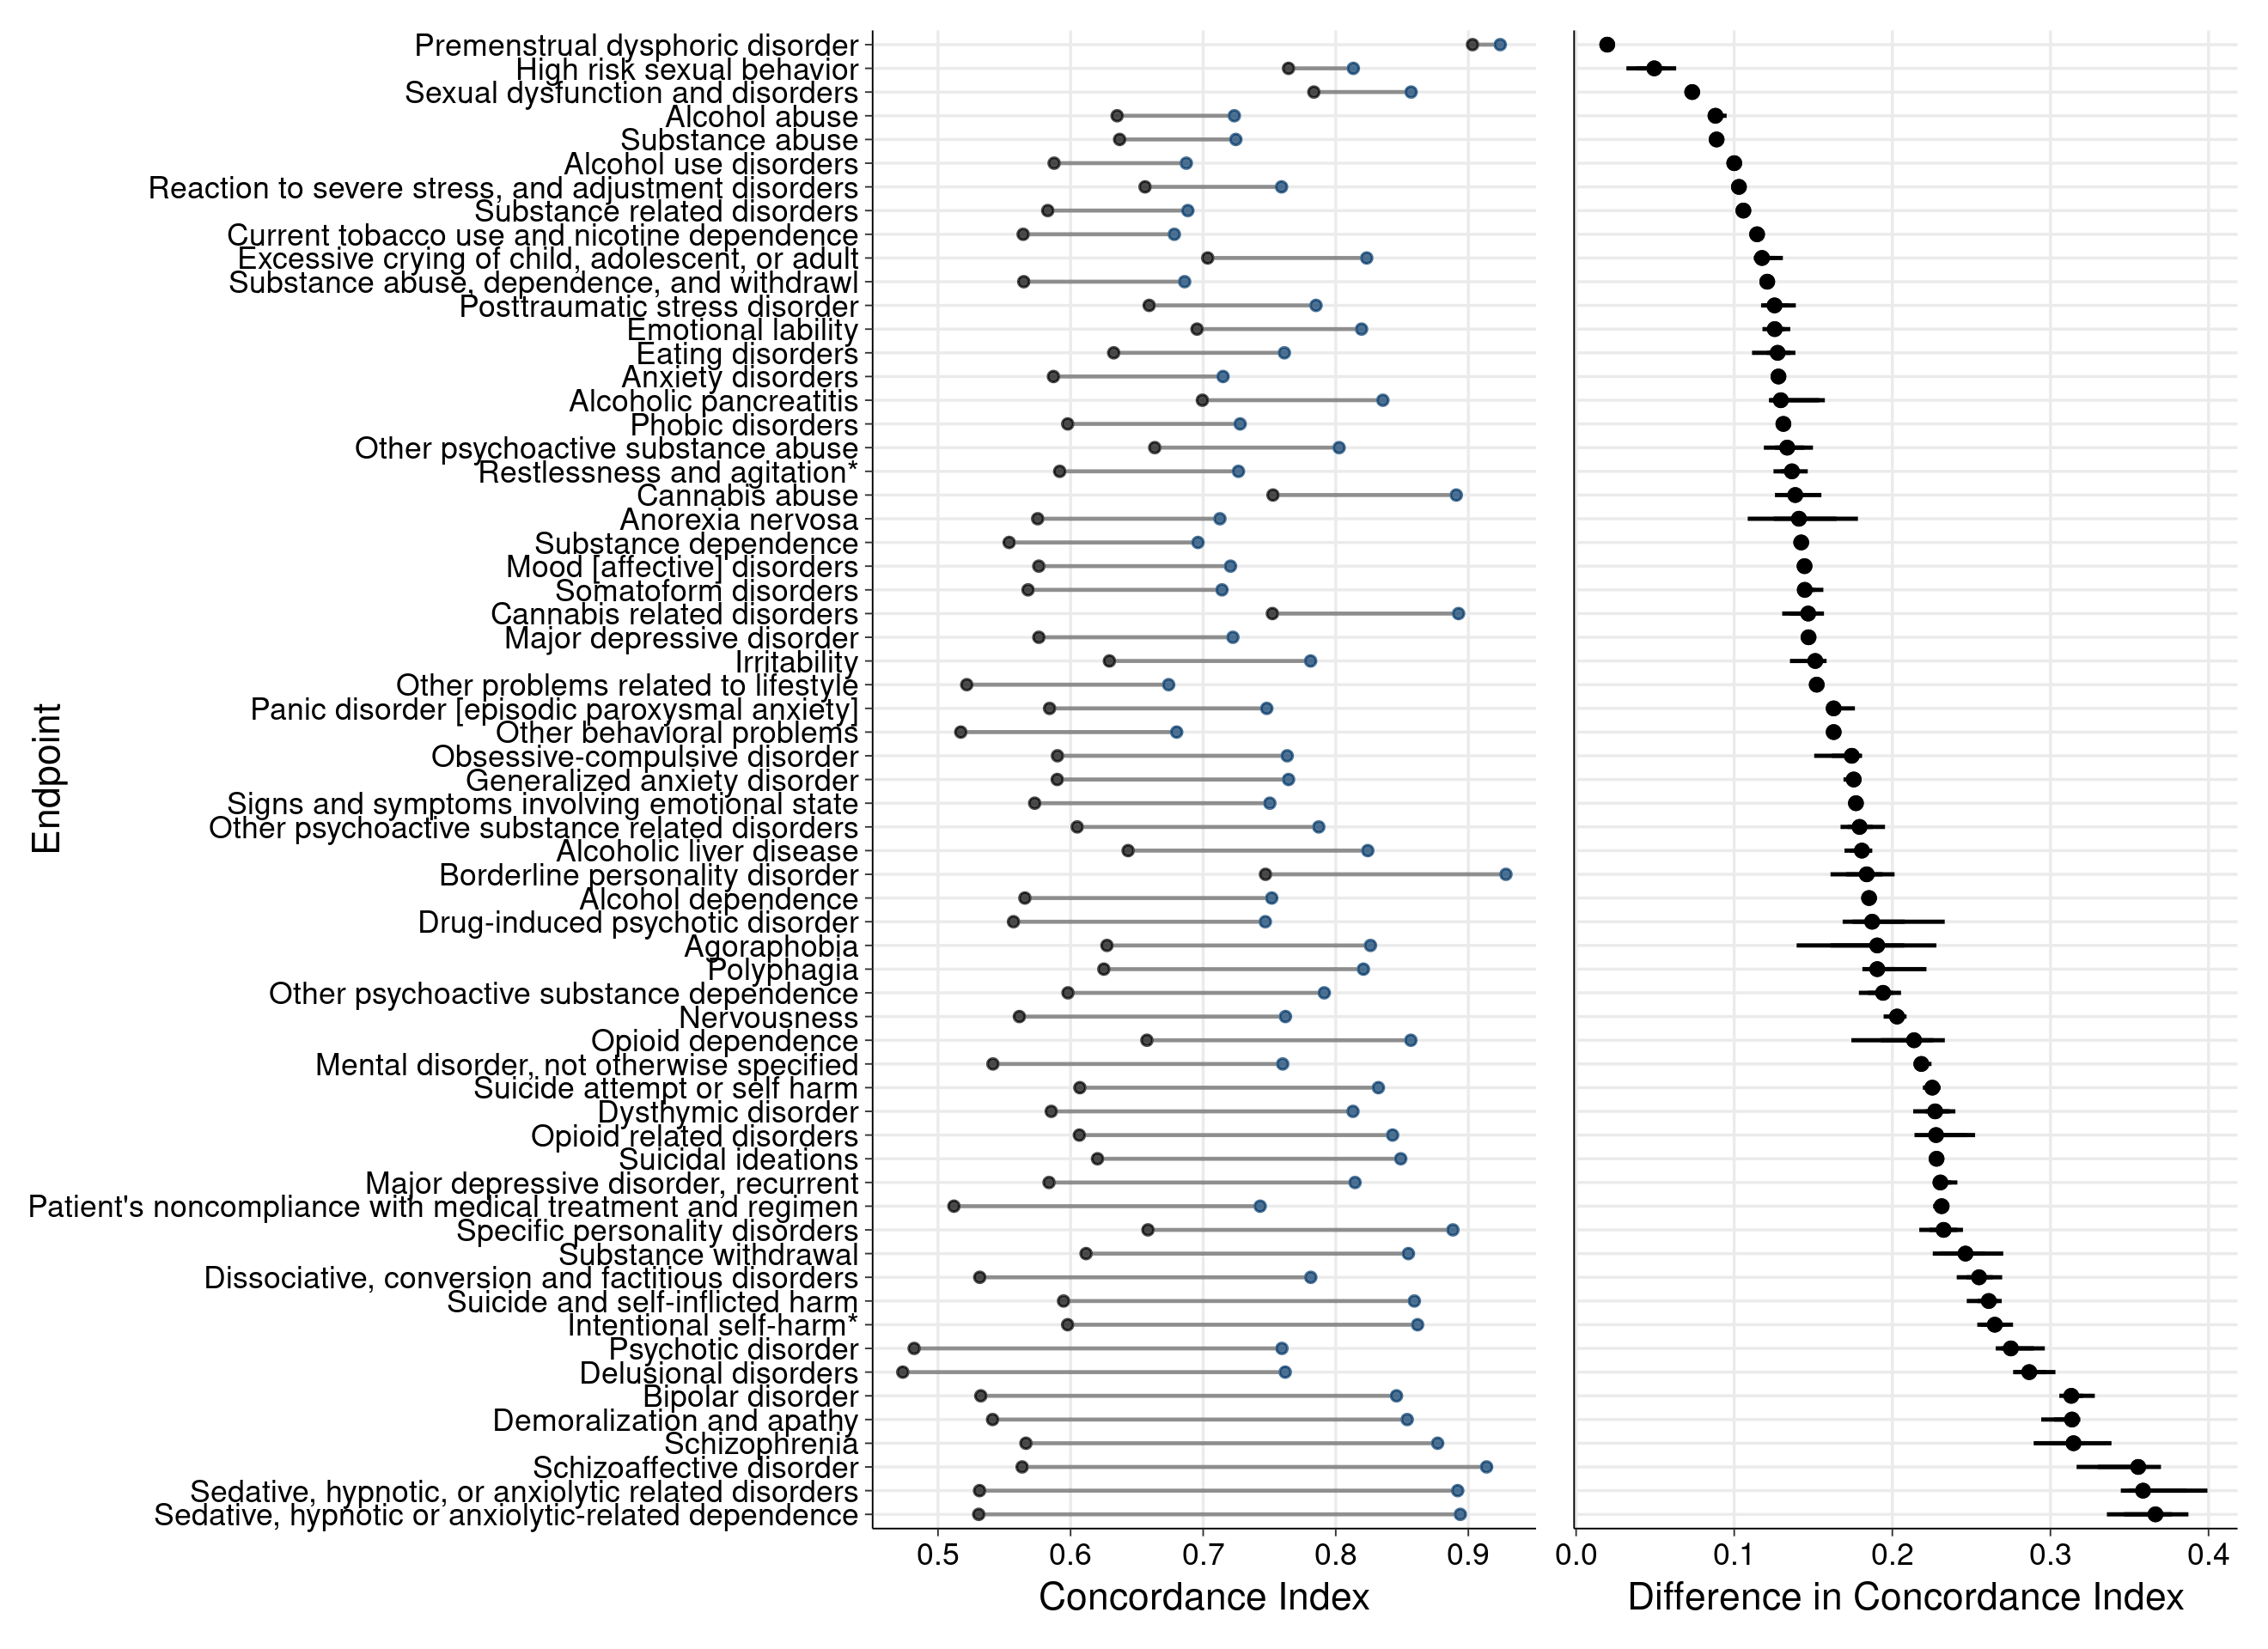

In [21]:
plot_width = 8.25; plot_height=6; plot_res = 320
options(repr.plot.width = plot_width, repr.plot.height = plot_height, repr.plot.res=plot_res)
abs|rel

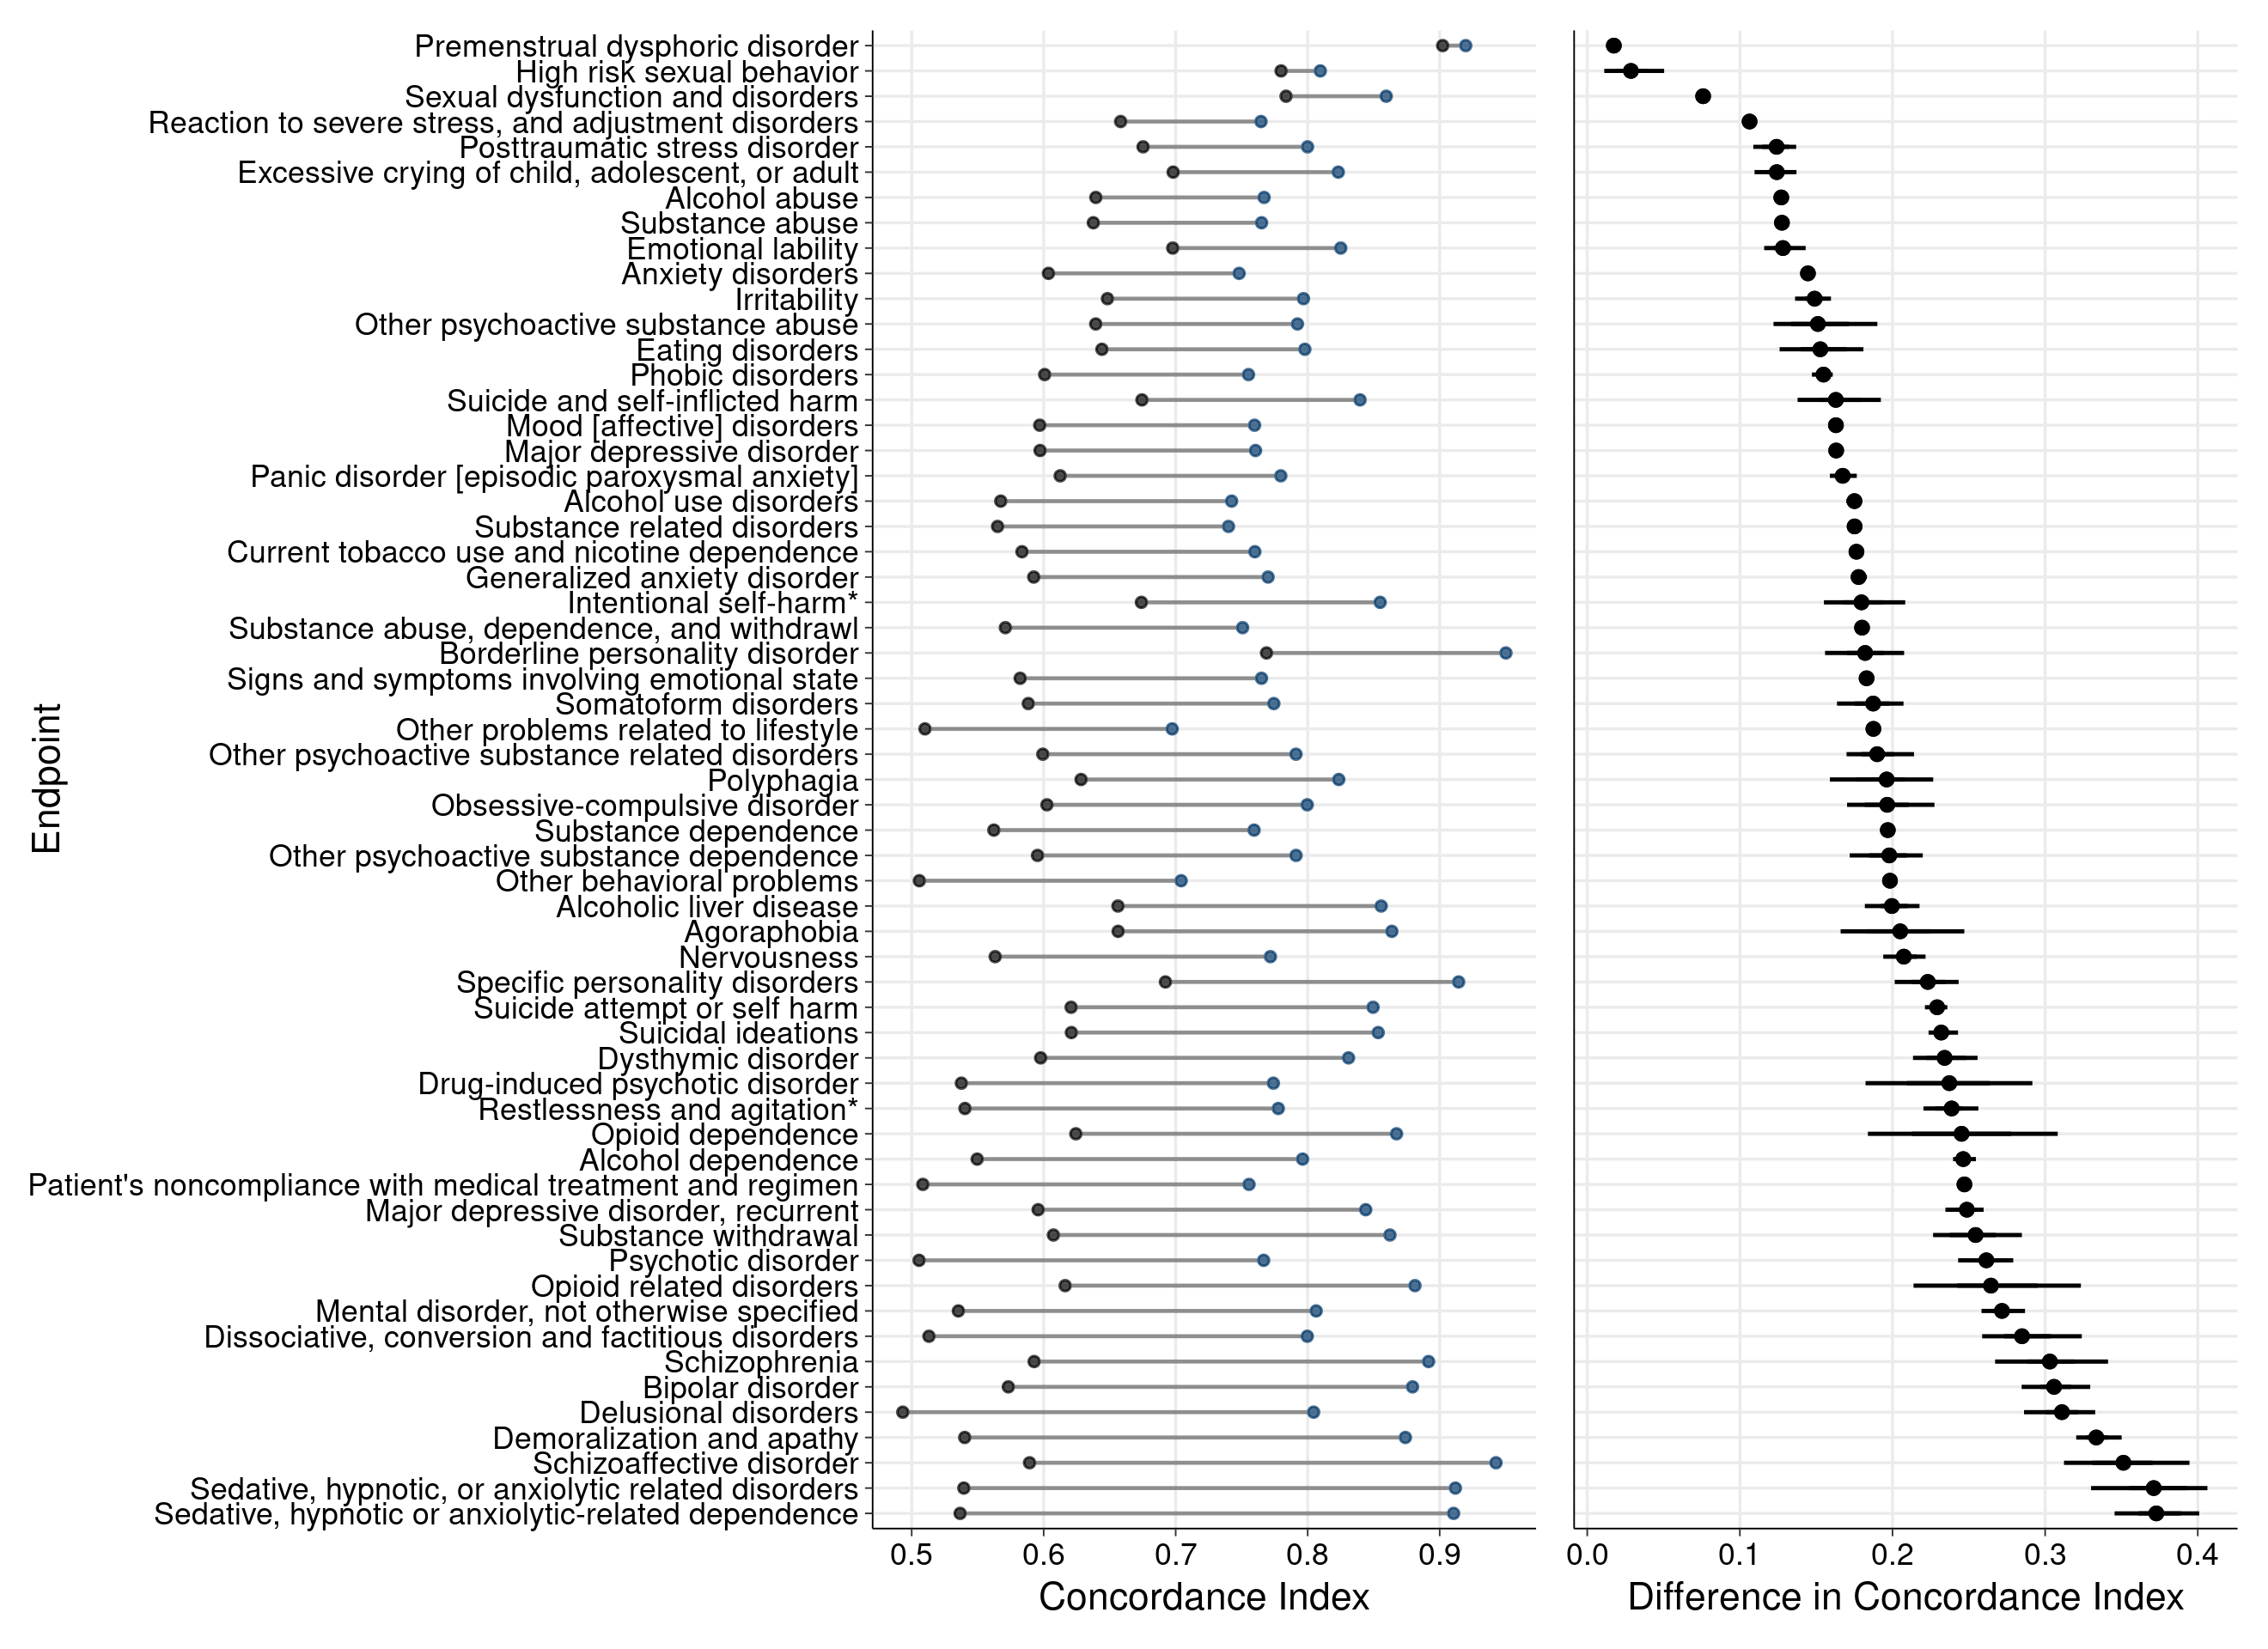

In [23]:
plot_width = 8.25; plot_height=6; plot_res = 320
options(repr.plot.width = plot_width, repr.plot.height = plot_height, repr.plot.res=plot_res)
abs|rel

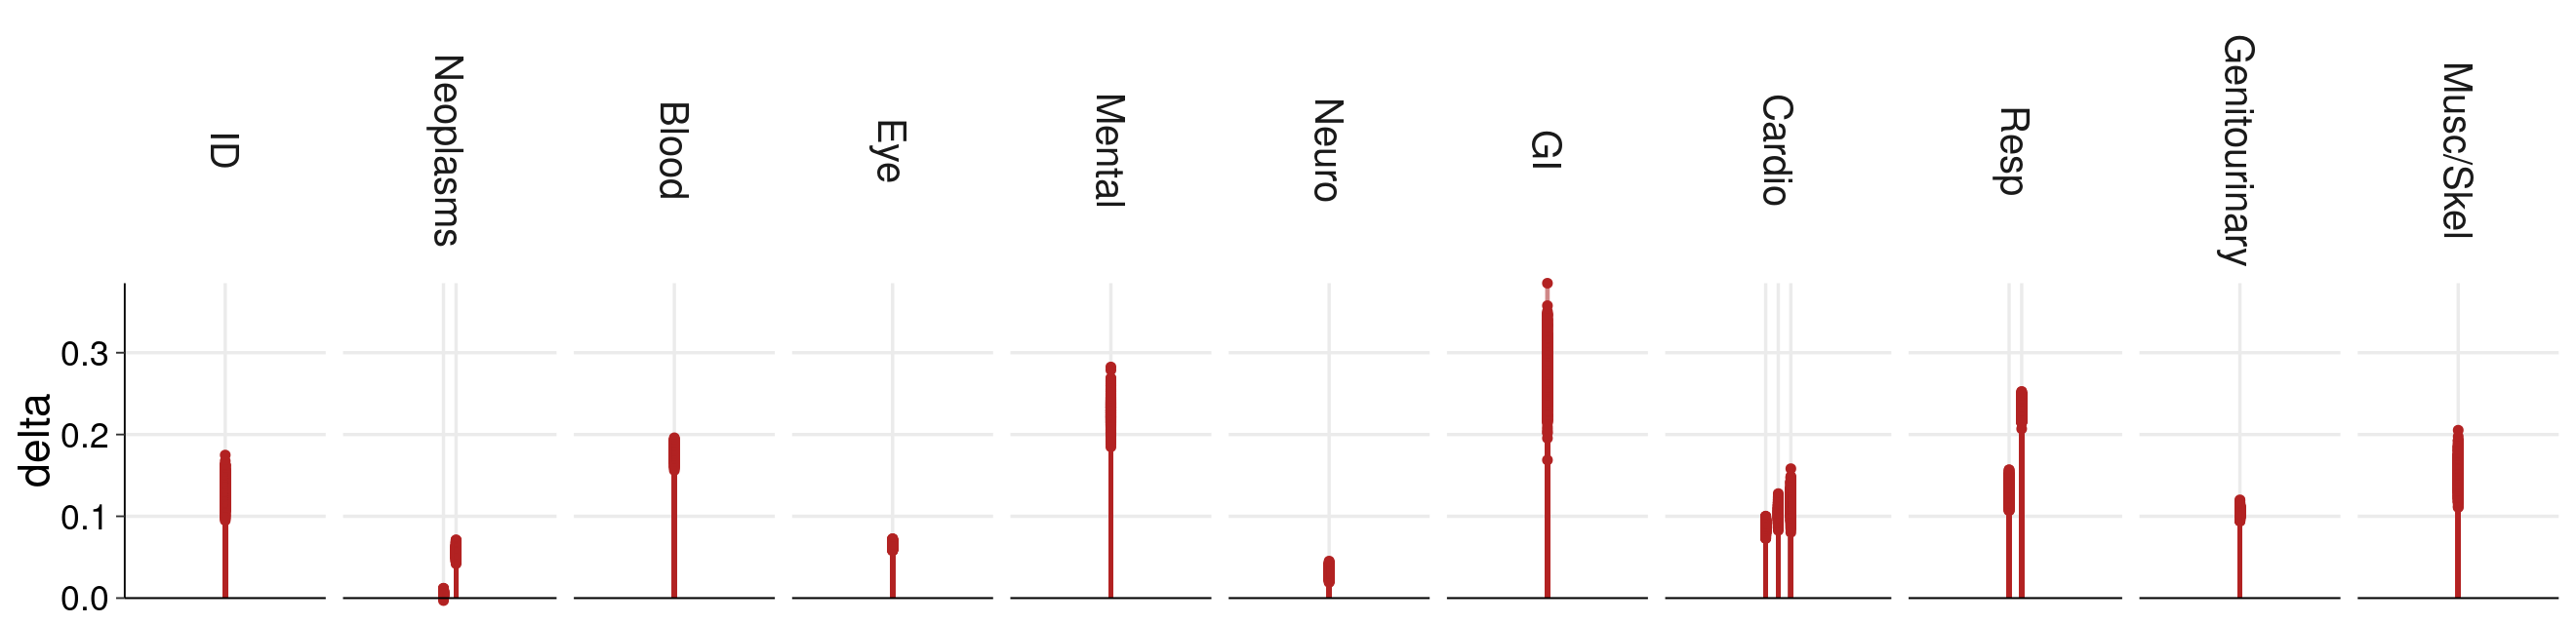

In [82]:
ggplot(temp) + 
    geom_point(aes(x=endpoint, y=delta, color=highlight), size=0.5) +
    geom_segment(aes(x=endpoint, xend=endpoint, y=0, yend=delta, color=highlight, size=highlight), alpha=0.5)+#+
    scale_color_manual(values=c("NO"="black", "YES"="firebrick"))+
    #scale_alpha_manual(values=c("NO"=0.3, "YES"=0.7))+
    scale_size_manual(values=c("NO"=0.1, "YES"=0.5))+
    #scale_colour_manual(values = c("pos"="forestgreen", "neg" = "firebrick")) + 
    coord_cartesian(ylim=c(0, NA), clip = "off")+
    scale_y_continuous(expand=c(0, 0))+
    scale_x_discrete(expand=expansion(add=8))+
    facet_grid(~phecode_category, scale="free_x", space="free_x")+#, switch=TRUE)+
    theme(axis.title.x=element_blank(),
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank(),
     strip.text = element_text(angle=270)) + 
    theme(legend.position="none")
    
    #geom_ribbon(aes(x=id, ymin=AgeSex, ymax=`Age+Sex+MedicalHistory`), fill="red", alpha=0.2)
#geom_violin(size=0.1) 

In [34]:
library(ggdist)

In [66]:
table_2 = benchmark_endpoints %>% 
    filter(score %in% scores_plot) %>% 
    mutate(score = factor(score, levels=scores_plot)) %>%
    mutate(endpoint = factor(endpoint, levels=endpoints_sorted)) %>%
    group_by(endpoint, score, phecode_string, phecode_category) %>%
    pivot_wider(names_from=score, values_from=cindex) %>% 
    mutate(id = row_number()) %>%
    mutate(delta = `Age+Sex+MedicalHistory`-`Age+Sex`) %>%
    #select(endpoint, iteration, phecode_string, phecode_category, sex, `Age+Sex`, `Age+Sex+MedicalHistory`, delta) %>%
    pivot_longer(all_of(c("Age+Sex", "Age+Sex+MedicalHistory", "delta")), names_to="type", values_to="cindex") %>%
    group_by(endpoint, phecode_string, phecode_category, type) %>%
    median_qi(cindex) %>%
    #ungroup() %>%
    mutate(agg = glue("{round(cindex, 3)} ({round(.lower, 3)}, {round(.upper, 3)})")) %>%
    ungroup() %>% select(endpoint, phecode_string, phecode_category, type, agg) %>%
    pivot_wider(names_from=type, values_from=agg)
    #mutate(pos = case_when(delta>=0 ~ "pos", delta < 0 ~"neg")) %>%
    #mutate(endpoint = fct_reorder(endpoint, delta))# %>% filter(endpoint %in% endpoint_sample)

In [36]:
table_2 %>% 
    select(all_of(c("endpoint", "phecode_string", "Age+Sex", 'Age+Sex+MedicalHistory', "delta"))) %>%
    mutate(endpoint = factor(endpoint, levels = endpoint_order)) %>% 
    filter(endpoint %in% endpoint_selection) %>%
    arrange(endpoint)

endpoint,phecode_string,Age+Sex,Age+Sex+MedicalHistory,delta
<fct>,<chr>,<glue>,<glue>,<glue>
phecode_092-2,Sepsis,"0.654 (0.651, 0.659)","0.714 (0.711, 0.718)","0.06 (0.056, 0.063)"
phecode_105,Malignant neoplasm of the breast,"0.757 (0.754, 0.759)","0.756 (0.754, 0.758)","-0.001 (-0.002, 0)"
phecode_164,Anemia,"0.599 (0.596, 0.601)","0.674 (0.672, 0.676)","0.075 (0.072, 0.077)"
phecode_287-5,Drug-induced psychotic disorder,"0.837 (0.83, 0.843)","0.941 (0.938, 0.945)","0.104 (0.098, 0.11)"
phecode_328,Dementias and cerebral degeneration,"0.637 (0.631, 0.642)","0.766 (0.761, 0.769)","0.129 (0.123, 0.134)"
phecode_404,Ischemic heart disease,"0.7 (0.699, 0.702)","0.741 (0.739, 0.743)","0.04 (0.039, 0.042)"
phecode_424,Heart failure,"0.655 (0.651, 0.659)","0.786 (0.783, 0.789)","0.132 (0.128, 0.135)"
phecode_440-11,Deep vein thrombosis [DVT],"0.617 (0.608, 0.629)","0.892 (0.888, 0.897)","0.275 (0.265, 0.285)"
phecode_468,Pneumonia,"0.657 (0.654, 0.66)","0.725 (0.723, 0.728)","0.069 (0.067, 0.071)"


In [272]:
options(pillar.print_max = Inf)
table_2 %>% 
    select(all_of(c("phecode_category", "endpoint", "phecode_string", "Age+Sex", 'Age+Sex+MedicalHistory', "delta"))) %>%
    mutate(endpoint = factor(endpoint, levels = endpoint_order)) %>% 
    #filter(endpoint %in% endpoint_selection) %>%
    arrange(endpoint) %>% 
    write_csv("outputs/SupplTable1_DiscriminativePerformanceAll.csv")

In [37]:
table_2 %>% filter(endpoint %in% endpoint_selection) %>% arrange(as.character(endpoint))

endpoint,phecode_string,phecode_category,Age+Sex,Age+Sex+MedicalHistory,delta
<fct>,<chr>,<chr>,<glue>,<glue>,<glue>
phecode_092-2,Sepsis,ID,"0.654 (0.651, 0.659)","0.714 (0.711, 0.718)","0.06 (0.056, 0.063)"
phecode_105,Malignant neoplasm of the breast,Neoplasms,"0.757 (0.754, 0.759)","0.756 (0.754, 0.758)","-0.001 (-0.002, 0)"
phecode_164,Anemia,Blood,"0.599 (0.596, 0.601)","0.674 (0.672, 0.676)","0.075 (0.072, 0.077)"
phecode_287-5,Drug-induced psychotic disorder,Mental,"0.837 (0.83, 0.843)","0.941 (0.938, 0.945)","0.104 (0.098, 0.11)"
phecode_328,Dementias and cerebral degeneration,Neuro,"0.637 (0.631, 0.642)","0.766 (0.761, 0.769)","0.129 (0.123, 0.134)"
phecode_404,Ischemic heart disease,Cardio,"0.7 (0.699, 0.702)","0.741 (0.739, 0.743)","0.04 (0.039, 0.042)"
phecode_424,Heart failure,Cardio,"0.655 (0.651, 0.659)","0.786 (0.783, 0.789)","0.132 (0.128, 0.135)"
phecode_440-11,Deep vein thrombosis [DVT],Cardio,"0.617 (0.608, 0.629)","0.892 (0.888, 0.897)","0.275 (0.265, 0.285)"
phecode_468,Pneumonia,Resp,"0.657 (0.654, 0.66)","0.725 (0.723, 0.728)","0.069 (0.067, 0.071)"
